In [1]:
import os
import pdb
import torch
import torch.nn as nn
import numpy as np
import pyro
import pyro.distributions as dist
import matplotlib.pyplot as plt

from pyro.infer import SVI, Trace_ELBO, TraceEnum_ELBO, config_enumerate, TraceMeanField_ELBO
from pyro.optim import PyroLRScheduler, ClippedAdam
from torch.optim.lr_scheduler import StepLR
from pyro import poutine
from pyro.infer import Predictive, infer_discrete

from bnpvae import DPMM, mix_weights

pyro.set_rng_seed(1234)

def create_sim_data(mu, sd, n_sim):
#     samples = dist.Normal(mu, sd).to_event(1).sample([n_sim])
    samples = dist.Normal(mu, sd).sample([n_sim])
    return samples


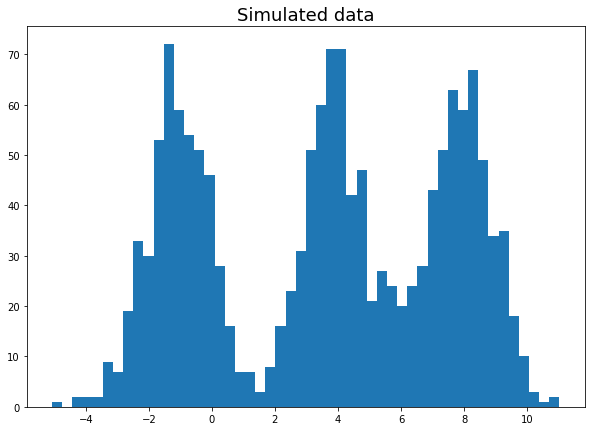

In [2]:
pyro.clear_param_store()

# Simulate data
num_sample = 500
loc = torch.tensor([[4],[-1],[8]]).float()
scale = torch.ones(1).float()
data = create_sim_data(loc, scale, num_sample)
x_data = data.view(-1, 1)

plt.figure(figsize=(10, 7))
plt.hist(x_data[:,0], bins=50)
plt.title("Simulated data", fontsize=18)
plt.savefig("figures/sim_data.png", bbox_inches="tight")

In [3]:
num_init_comp = 5
mu_init = torch.linspace(-5,10, steps=num_init_comp).unsqueeze(1).float()
# mu_init = torch.tensor([[4],
#                         [-4],[0],[10]]).float()
sd_q1 = torch.ones_like(mu_init)*0.5
sd_q2 = torch.ones_like(mu_init)*0.3
pi_c = dist.Dirichlet(1/num_init_comp * torch.ones(num_init_comp)).sample([x_data.size(0)])
prior_val = {"mu_c": mu_init, "sd_q1": sd_q1, "sd_q2": sd_q1, "pi_c":pi_c}

In [4]:
pyro.clear_param_store()
losses=[]
batch_size = 200
n_epoch = 200
model = DPMM(latent_dim=1, num_T=num_init_comp, init_prior=prior_val, num_obs=x_data.size(0))

# Calculate mini-batch samples indices
split_idx = torch.arange(0,x_data.size(0),batch_size)
rand_idx = torch.randperm(x_data.size(0))

# Initialize optimizer
optimizer = torch.optim.Adam
scheduler = PyroLRScheduler(StepLR, {'optimizer': optimizer,
                                     'optim_args': {'lr': 0.05, 'betas':[0.9,0.95]},
                                     'gamma': 0.9, "step_size": 1000},{"clip_norm": 1.})

basic_svi = SVI(config_enumerate(model.model), config_enumerate(model.guide), scheduler, loss=TraceEnum_ELBO(max_plate_nesting=1))

for it in range(n_epoch):
    epoch_loss = 0
    for ii in range(split_idx.size(0)-1):
        start_idx = split_idx[ii]
        end_idx = split_idx[ii+1]
        epoch_loss += basic_svi.step(x_data, rand_idx[start_idx:end_idx])
    epoch_loss /= split_idx.size(0)
    losses.append(epoch_loss)


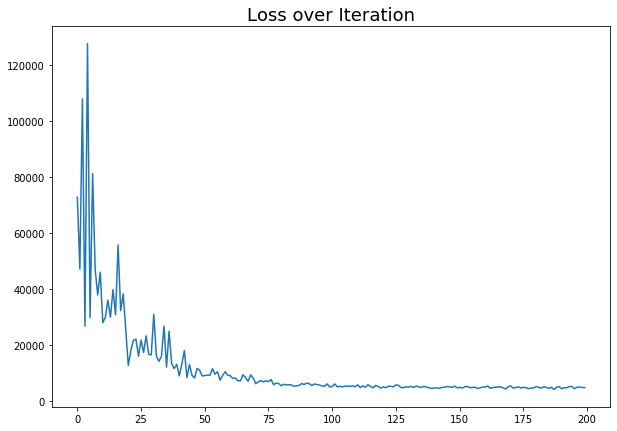

In [10]:
plt.figure(figsize=(10,7))
plt.plot(np.array(losses))
plt.title("Loss over Iteration", fontsize=18)
# plt.show()
plt.savefig("figures/enum_loss.png", bbox_inches="tight")

In [6]:
# We can sample from posterior distribution like this (Posterior samples)
predictive = Predictive(model.model, guide=model.guide, num_samples=1000)
svi_samples = {key: value.detach().cpu() for key, value in predictive(x_data, torch.arange(x_data.size(0))).items()}
model.update_component_stats(svi_samples)
print(model.component_weights)
print(model.component_loc)
# print(torch.mean(svi_samples["mu"], dim=0))
# print(torch.mean(svi_samples["musd"], dim=0))

tensor([0.2772, 0.0950, 0.3122, 0.0287, 0.2870])
tensor([[-0.9814],
        [-0.8770],
        [ 4.0422],
        [ 5.9142],
        [ 8.0325]])


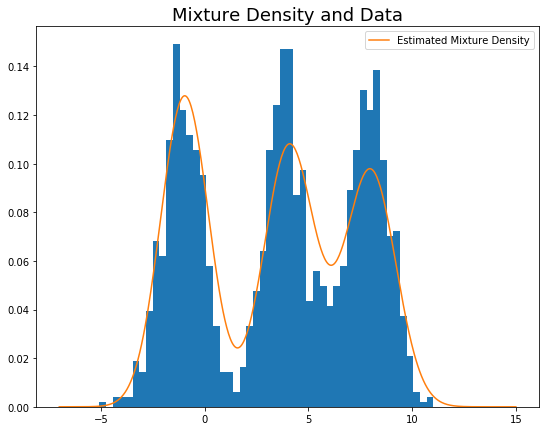

In [8]:
x_samples = torch.linspace(-7,15, steps=500)
norm_lik = model.likelihood(x_samples.unsqueeze(1))

plt.figure(figsize=(9,7))
plt.hist(x_data[:,0], bins=50, density=True)
plt.plot(x_samples, norm_lik, label="Estimated Mixture Density")
plt.title("Mixture Density and Data", fontsize=18)
plt.legend()
plt.savefig("figures/posterior_check.png",bbox_inches="tight")
# plt.show()

In [ ]:
sel_idx = torch.argmin(torch.abs(model.component_loc - loc[0]))

In [ ]:
sel_idx = []
tru_mu = []
for ii in range(loc.size(0)):
    tru_mu.append(loc[ii])
    sel_idx.append(torch.argmin(torch.abs(model.component_loc - loc[ii])))

plt.figure(figsize=(10,9))
plt.subplot(221)
plt.hist(svi_samples["mu"][:,sel_idx[0],0], bins=50)
plt.axvline(x=tru_mu[0],color='red')
plt.title(r"$\mu_1$", fontsize=20)
plt.subplot(222)
plt.hist(svi_samples["mu"][:,sel_idx[1],0], bins=50)
plt.axvline(x=tru_mu[1],color='red')
plt.title(r"$\mu_2$", fontsize=20)
plt.subplot(223)
plt.hist(svi_samples["mu"][:,sel_idx[2],0], bins=50)
plt.axvline(x=tru_mu[2],color='red')
plt.title(r"$\mu_3$", fontsize=20)
plt.savefig("figures/mu_post.png", bbox_inches='tight')

In [ ]:
plt.figure(figsize=(10,9))
plt.subplot(221)
plt.hist(svi_samples["musd"][:,sel_idx[0],0], bins=50)
plt.axvline(x=1,color='red')
plt.title(r"$\sigma_1$", fontsize=20)
plt.subplot(222)
plt.hist(svi_samples["musd"][:,sel_idx[1],0], bins=50)
plt.axvline(x=1,color='red')
plt.title(r"$\sigma_2$", fontsize=20)
plt.subplot(223)
plt.hist(svi_samples["musd"][:,sel_idx[2],0], bins=50)
plt.axvline(x=1,color='red')
plt.title(r"$\sigma_3$", fontsize=20)
plt.savefig("figures/sigma_post.png", bbox_inches='tight')

In [ ]:
num_sample = 1
test_loc = torch.tensor([[8],
                    [4],[-1]]).float()
data = create_sim_data(test_loc, scale, num_sample)
test_data = torch.cat([data[:, 0], data[:, 1], data[:,2]], dim=0)


In [ ]:
plt.hist(posterior_sample["mu"][:,3,0],bins=50)
plt.show()

In [ ]:
posterior_sample = {}
posterior_sample["beta"] = torch.mean(svi_samples["beta"],dim=0)
posterior_sample["mu"] = torch.mean(svi_samples["mu"],dim=0)
posterior_sample["musd"] = torch.mean(svi_samples["musd"],dim=0)
# posterior_sample["beta"] = svi_samples["beta"]
# posterior_sample["mu"] = svi_samples["mu"]
# posterior_sample["musd"] = svi_samples["musd"]
# posterior_sample["cat"] = svi_samples["cat"]
# posterior_sample["obs"] = test_data[0].unsqueeze(0)
# posterior_sample["obs"] = x_data.unsqueeze(0)
posterior_sample["obs"] = x_data

In [ ]:
torch.argmax(dist.Normal(posterior_sample["mu"], posterior_sample["musd"]).log_prob(test_data[0]).exp())

In [ ]:
plt.hist(an_arr)
plt.show()

In [ ]:
# conditioned_model = poutine.condition(model.model, data=posterior_sample)
trace_pred = Predictive(model.model, posterior_sample)(test_data[0].unsqueeze(0).repeat(1,1), torch.arange(1))
# trace_pred = Predictive(model.model, guide=model.guide, num_samples=100)(x_data, torch.arange(1500))
trace_pred["cat"]

# plt.hist(trace_pred["cat"].view(-1), density=True)
# plt.show()

# Merge and Prune Components

In [ ]:
# Function to check KL divergence between comp_idx and other idx
def check_dist(comp_idx):
    kl_div = []
    def model_kl():
        mu = model.component_loc[comp_idx]
        scale=model.component_sd[comp_idx]
        pyro.sample("z_kl", dist.Normal(mu, scale))
        pyro.sample("obs_kl", dist.Normal(0.0, 1.0), obs=torch.tensor([0.3]))

    for nn in range(model.T):
        def guide_kl():
            mu = model.component_loc[nn]
            scale=model.component_sd[nn]
            pyro.sample("z_kl", dist.Normal(mu, scale))

        model_no_obs = poutine.block(model_kl, hide=["obs_kl"])
        optim = pyro.optim.Adam({"lr": 0.001})
        svi = SVI(model_no_obs, guide_kl, optim, TraceMeanField_ELBO())
        kl_div.append(svi.evaluate_loss())
    return kl_div


In [ ]:
weight_threshold = 0.01
mask = model.component_weights < 0.01
num_prune = torch.sum(mask)
print(num_prune)
# model.T = model.T - num_prune
# model.alpha_q.data = model.alpha_q.data[:-num_prune]

In [ ]:
model.alpha_q[:-1]
# model.component_weights

In [ ]:
print(model.component_weights)
val, c_idx = torch.topk(model.component_weights,k=1)
print(c_idx)
kl_div = check_dist(c_idx[0].item())
print(kl_div)
val, merge_idx = torch.topk(torch.tensor(kl_div), 2, largest=False)
print(merge_idx[1].item())

In [ ]:
c_idx = 7
kl_div = check_dist(c_idx)
val, merge_idx = torch.topk(torch.tensor(kl_div), 2, largest=False)
merge_idx = 6
# if merge_idx[1].item() < c_idx:
#     tmp_merge = merge_idx[1].item()
#     merge_idx = c_idx
#     c_idx = tmp_merge

if val[1] < 1.0:
#     merge_idx = merge_idx[1].item()

    model.T = model.T - 1

    model.alpha_q.data[-2] += model.alpha_q.data[-1]
#     prune_mask = torch.arange(model.alpha_q.size(0)) != (merge_idx-1)
    model.alpha_q.data = model.alpha_q.data[:-1]

    c_weight = torch.mean(pyro.param("pi_q").detach(),dim=0)[c_idx]
    m_weight = torch.mean(pyro.param("pi_q").detach(),dim=0)[merge_idx]
    total_weight = c_weight + m_weight

    model.pi_c.data[:, c_idx] = model.pi_c.data[:,merge_idx] + model.pi_c.data[:,c_idx]
    prune_mask = torch.arange(model.pi_c.size(1)) != merge_idx
    model.pi_c.data = model.pi_c.data[:,prune_mask]

    model.mu_c.data[c_idx] = (c_weight/total_weight)*model.mu_c.data[c_idx] + (m_weight/total_weight)*model.mu_c.data[merge_idx]
    model.sd_q1.data[c_idx] = (c_weight/total_weight)*model.sd_q1.data[c_idx] + (m_weight/total_weight)*model.sd_q1.data[merge_idx]
    model.sd_q2.data[c_idx] = (c_weight/total_weight)*model.sd_q2.data[c_idx] + (m_weight/total_weight)*model.sd_q2.data[merge_idx]
#     model.component_sd[c_idx] = (c_weight/total_weight)*model.component_sd[c_idx] + (m_weight/total_weight)*model.component_sd[merge_idx]
    prune_mask = torch.arange(model.mu_c.size(0)) != merge_idx
    model.mu_c.data = model.mu_c.data[prune_mask]
    model.sd_q1.data = model.sd_q1.data[prune_mask]
    model.sd_q2.data = model.sd_q2.data[prune_mask]
#     model.component_sd = model.component_sd[prune_mask]

    pyro.get_param_store()["alpha_q"] = model.alpha_q
    pyro.get_param_store()["pi_q"] = model.pi_c
    pyro.get_param_store()["mu_c"] = model.mu_c
    pyro.get_param_store()["sd_q1"] = model.sd_q1
    pyro.get_param_store()["sd_q2"] = model.sd_q2
    
svi_samples = {key: value.detach().cpu() for key, value in predictive(x_data, torch.arange(x_data.size(0))).items()}
model.update_component_stats(svi_samples)

In [ ]:
model.component_weights

In [ ]:
model.predict(test_data1)